# Some global things

In [1]:
### Global
import numpy as np

from scipy.interpolate import interp1d
from scipy.integrate import simps
from chainconsumer import ChainConsumer

import matplotlib.pyplot as plt

### Local
from utilities_simplified import *

### For plotting
import matplotlib
matplotlib.rcParams['text.usetex'] = True
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rcParams.update({'axes.labelsize': 20, 'legend.fontsize': 20 })

In [2]:
### GW150914 parameters 
### Are these the masses in detector's frame???
m1   = 36       #solarmass
m2   = 29

dL   = 410      #Mpc
zem  = 0.09

yr_s = 365 *24 *3600 
t_yr = 2.
time = t_yr *yr_s # time before merger in sec
tc   = 0
psic = 0

H    = cosmo_params['h'] *100 *1e3 /Mpc

In [3]:
#Read in and interpolate LIGO and LISA PSDs.
path_to_data = '../../data/'

ligo_data    = np.genfromtxt(path_to_data 
                +'lalsimulation_lib_LIGO-T1800545-v1-aLIGO_175Mpc.txt')
LISA_strain  = np.loadtxt(path_to_data+'LISA_strain.txt')

ligo_interp  = interp1d(ligo_data[:,0], ligo_data[:,1])
lisa_interp  = interp1d(LISA_strain[:,0], LISA_strain[:,3])

fligo   = np.logspace(np.log10(ligo_data[0,0]), np.log10(ligo_data[-1,0]), 1000)
flisa   = np.logspace(np.log10(LISA_strain[0,0]), np.log10(LISA_strain[-1,0]), 1000)

In [4]:
### Get dL
dL_s   = dL *Mpc  *c    # Dl in sec

### Get mass quantities (are these in source or detector frame???)
m_eff  = m1 *m2 /(m1+m2)
Ms     = m_eff**(3. /5) * (m1 +m2)**(2./5)     # chirp mass in solarmass
eta    = ((m1 +m2) /Ms)**(-5./3)

Ms_s   = Ms *Msolar *GN /c**3.       # chirp mass in sec
Mtot_s = (m1+m2) *Msolar *GN /c**3.


### Get frequency ranges for inspiral and plots
# starting frequency at the time before merger
f_start = (5 *Ms_s /256 /time)**(3./8) /np.pi /Ms_s  

#### NB!!!!! inspiral_fc wants redshifted total mass why is this source?
fc      = inspiral_fc(Mtot_s)
farr    = np.logspace(np.log10(f_start), np.log10(fc),num=500)     # inspiral range only
Dl_arr  = np.array([dL_s]*len(farr))

In [5]:
to_int  = 1 /( 96/5 * np.pi**(8/3) *(Ms_s)**(5/3) *farr[:194]**(11/3) )
simps(to_int, x=farr[:194]) /365.25 /24 /3600

1.9981334471769683

In [6]:
pars_GR     = np.array([np.log(Ms), np.log(eta), np.log(zem), tc, psic, 0, 0])
label_GR    = [r'$\Delta \ln \left( \frac{ {\cal M}_o }{ M_{\odot} } \right)$', r'$ \Delta \ln \eta $', r'$\Delta \ln z $',r'$\Delta t_c$ [ms]',r'$ \Delta \Psi_c$']

In [7]:
# Get waveform segments in LISA and LIGO ranges only.
n_points  = 500
farr_ligo = np.logspace(np.log10(ligo_data[0,0]), np.log10(fc),num=n_points)
farr_lisa = np.logspace(np.log10(f_start),np.log10(LISA_strain[-1,0]),num=n_points)

ligo_psd  = ligo_interp(farr_ligo)**2
lisa_psd  = lisa_interp(farr_lisa)

h_GR_ligo = h_Delta_inspiral(farr_ligo, pars_GR, dist_corr=False)
h_GR_lisa = h_Delta_inspiral(farr_lisa, pars_GR, dist_corr=False)

print('SNR LIGO = %.2f, SNR LISA = %.2f' % ( scalar_product(h_GR_ligo, h_GR_ligo, ligo_psd, farr_ligo)**(.5), 
      scalar_product(h_GR_lisa, h_GR_lisa, lisa_psd, farr_lisa)**(.5) ) )

SNR LIGO = 65.53, SNR LISA = 3.43


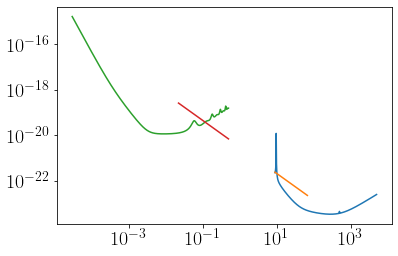

In [8]:
plt.loglog(fligo, ligo_interp(fligo))
plt.loglog(farr_ligo, np.abs(h_GR_ligo))

plt.loglog(flisa, np.sqrt(lisa_interp(flisa)) ) 
plt.loglog(farr_lisa, np.abs(h_GR_lisa));

# GR Constraints

In [9]:
### Start with LIGO!!! 
wf_ligo_nd = h_Delta_inspiral(farr_ligo, pars_GR, cT_type='GR')

dlnA_ligo_GR, dPsi_ligo_GR = Fisher_der(farr_ligo, pars_GR, cT_type='GR')

FlnA_ligo_GR = Fisher_build(farr_ligo, ligo_psd, wf_ligo_nd, dlnA_ligo_GR)
FPsi_ligo_GR = Fisher_build(farr_ligo, ligo_psd, wf_ligo_nd, dPsi_ligo_GR)

-Working on index 0
Ratio best = 2.80e-14 for dx = 3.34e-01
Ratio best = 5.68e-03 for dx = 1.67e-01
-Working on index 1
Ratio best = 2.42e-03 for dx = 1.40e-01
-Working on index 2
-Working on index 3
-Working on index 4
-Working on index 5
This took 1.96 seconds


In [10]:
fisher_ligo_GR       = FlnA_ligo_GR +FPsi_ligo_GR
cov_matrix_ligo_GR   = np.linalg.inv(fisher_ligo_GR)
pconstraints_ligo_GR = np.sqrt(np.diag(cov_matrix_ligo_GR))

print('\nLIGO conditioning (units of 1e15)')
print(np.linalg.cond(fisher_ligo_GR)/1e15)
print('\nLIGO GR constraints')
print(pconstraints_ligo_GR)


LIGO conditioning (units of 1e15)
1.0748992281844181e-08

LIGO GR constraints
[0.00423815 0.06449196 0.0147596  0.00048466 0.1698592 ]


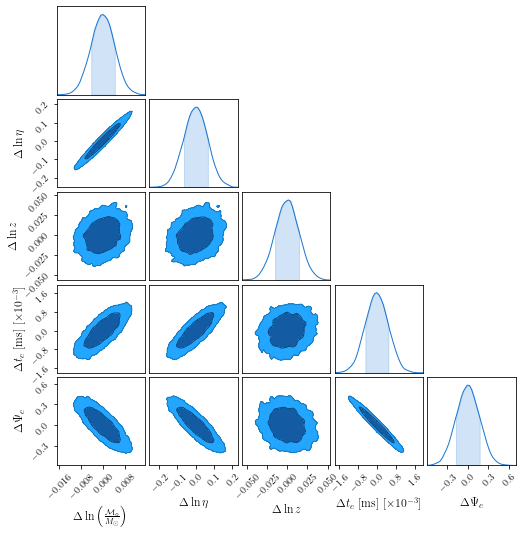

In [11]:
data_ligo_GR = np.random.multivariate_normal(0 *pars_GR[:-2], cov_matrix_ligo_GR, size=10000)

cc = ChainConsumer()
cc.add_chain(data_ligo_GR, bins=30, smooth=True, parameters=label_GR, name='ligo');
cc.plotter.plot();

In [12]:
### Then with LISA, NO DIST corr here!!! 
wf_lisa = h_Delta_inspiral(farr_lisa, pars_GR, cT_type='GR', dist_corr=False)

dlnA_lisa_GR, dPsi_lisa_GR = Fisher_der(farr_lisa, pars_GR, cT_type='GR', dist_corr=False)

FlnA_lisa_GR = Fisher_build(farr_lisa, lisa_psd, wf_lisa, dlnA_lisa_GR)
FPsi_lisa_GR = Fisher_build(farr_lisa, lisa_psd, wf_lisa, dPsi_lisa_GR)

-Working on index 0
Ratio best = 1.70e-14 for dx = 3.34e-01
Ratio best = 5.67e-03 for dx = 1.67e-01
-Working on index 1
Ratio best = 3.41e-03 for dx = 1.40e-01
-Working on index 2
-Working on index 3
-Working on index 4
-Working on index 5
This took 1.96 seconds


In [13]:
fisher_lisa_GR       = FlnA_lisa_GR +FPsi_lisa_GR
cov_matrix_lisa_GR   = np.linalg.inv(fisher_lisa_GR)
pconstraints_lisa_GR = np.sqrt(np.diag(cov_matrix_lisa_GR))

print('\nLISA conditioning (units of 1e15)')
print(np.linalg.cond(fisher_lisa_GR)/1e15)
print('\nLISA GR constraints')
print(pconstraints_lisa_GR)

evals_lisa_GR, evecs_lisa_GR = np.linalg.eigh(fisher_lisa_GR)
print('\nEigenvals:\n', evals_lisa_GR)

print('\nSmallest eigenval:\n', evecs_lisa_GR[0,:])
print('\nLargest eigenval:\n', evecs_lisa_GR[-1,:])


LISA conditioning (units of 1e15)
8.835461893307054

LISA GR constraints
[7.23091295e-06 4.75256524e-02 2.74527607e-01 3.63968612e+00
 4.07413738e+00]

Eigenvals:
 [4.67898525e-02 1.17981521e-01 1.32686871e+01 9.08091173e+03
 4.13409959e+14]

Smallest eigenval:
 [ 1.03094466e-06 -1.79828868e-06 -1.91499663e-11  1.40007981e-04
  9.99999990e-01]

Largest eigenval:
 [ 7.93695290e-01 -6.08186482e-01  1.51338490e-06 -1.25295275e-02
 -1.57716934e-07]


In [14]:
### Reducing magnitude of some parameters and computing new fisher
new_dlnA_lisa_GR = np.array(dlnA_lisa_GR)
new_dPsi_lisa_GR = np.array(dPsi_lisa_GR)

rescaling_matrix      = np.eye( len(dlnA_lisa_GR) )
rescaling_matrix[0,0] = 1e-4 #3e-3
rescaling_matrix[1,1] = 1e-4 #1e-7
rescaling_matrix[2,2] = 1e0
rescaling_matrix[3,3] = 1 #1e-1
rescaling_matrix[4,4] = 1 #1e-1

#d_new_ligo = np.matmul(rescaling_matrix, ders_ligo_GR_dist)
new_dlnA_lisa_GR = np.matmul(rescaling_matrix, new_dlnA_lisa_GR)
new_dPsi_lisa_GR = np.matmul(rescaling_matrix, new_dPsi_lisa_GR)

new_FlnA_lisa_GR = Fisher_build(farr_lisa, lisa_psd, wf_lisa, new_dlnA_lisa_GR)
new_FPsi_lisa_GR = Fisher_build(farr_lisa, lisa_psd, wf_lisa, new_dPsi_lisa_GR)

F_lisa_GR = new_FlnA_lisa_GR +new_FPsi_lisa_GR

cov_lisa_GR  = np.linalg.inv(F_lisa_GR)

print('Conditioning / 1e15:', np.linalg.cond(F_lisa_GR)/1e15)

Conditioning / 1e15: 0.0009338216186197494


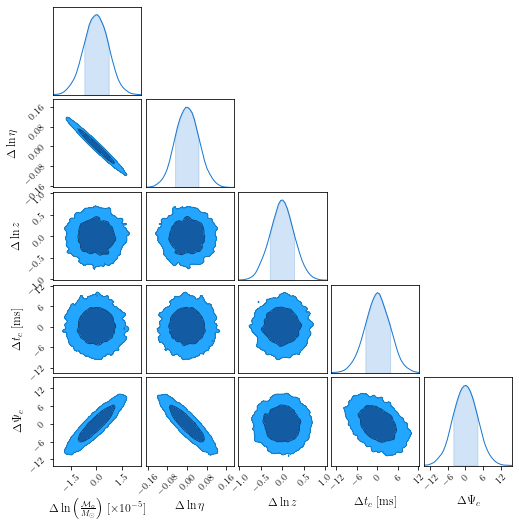

In [15]:
cov_matrix_lisa_GR = np.matmul(rescaling_matrix, np.matmul(cov_lisa_GR, rescaling_matrix))
data_lisa_GR = np.random.multivariate_normal(0 * pars_GR[:-2], cov_matrix_lisa_GR, size=10000)

cc = ChainConsumer()
cc.add_chain(data_lisa_GR, bins=30, smooth=True, parameters=label_GR, name='lisa');
cc.plotter.plot();

In [16]:
fisher_tot_GR = fisher_ligo_GR +fisher_lisa_GR
print('Combined conditioning (units 1e15) ', np.linalg.cond(fisher_tot_GR)/1e5)

evals_tot_GR, evecs_tot_GR = np.linalg.eigh(fisher_tot_GR)
print('\nEigenvals:\n', evals_tot_GR)

print('\nSmallest eigenval:\n', evecs_tot_GR[0,:])
print('\nLargest eigenval:\n', evecs_tot_GR[-1,:])

Combined conditioning (units 1e15)  28632925.002066925

Eigenvals:
 [1.44382723e+02 4.84957067e+03 5.63855072e+04 3.33124302e+08
 4.13409967e+14]

Smallest eigenval:
 [ 1.05512232e-05 -1.35963571e-09 -1.39622694e-04  5.30522217e-07
  9.99999990e-01]

Largest eigenval:
 [ 9.97236364e-01  9.28188020e-06  7.42165833e-02 -3.39596273e-03
 -1.57942507e-07]


In [17]:
### Reducing magnitude of some parameters and computing new fisher
rescaling_matrix      = np.eye( len(dlnA_lisa_GR) )
rescaling_matrix[0,0] = 1e-2 #3e-3
rescaling_matrix[1,1] = 1e-2 #1e-7
rescaling_matrix[2,2] = 1e0
rescaling_matrix[3,3] = 1 #1e-1
rescaling_matrix[4,4] = 1 #1e-1

#d_new_ligo = np.matmul(rescaling_matrix, ders_ligo_GR_dist)
new_fisher_tot_GR = np.matmul(rescaling_matrix, np.matmul(fisher_tot_GR, rescaling_matrix))

new_cov_tot_GR = np.linalg.inv(new_fisher_tot_GR)

print('Conditioning / 1e15:', np.linalg.cond(new_fisher_tot_GR)/1e15)

Conditioning / 1e15: 2.3263130434706436e-05


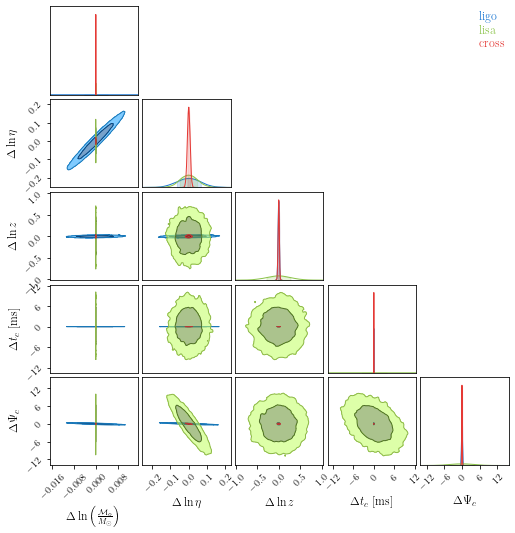

In [18]:
cov_tot_GR  = np.matmul(rescaling_matrix, np.matmul( np.linalg.inv(new_fisher_tot_GR), rescaling_matrix) )
data_tot_GR = np.random.multivariate_normal(0 *pars_GR[:-2], cov_tot_GR, size=10000)

cc = ChainConsumer()
cc.add_chain(data_ligo_GR, bins=30, smooth=True, parameters=label_GR, name='ligo');
cc.add_chain(data_lisa_GR, bins=30, smooth=True, parameters=label_GR, name='lisa');
cc.add_chain(data_tot_GR, bins=30, smooth=True, parameters=label_GR, name='cross');
cc.plotter.plot();

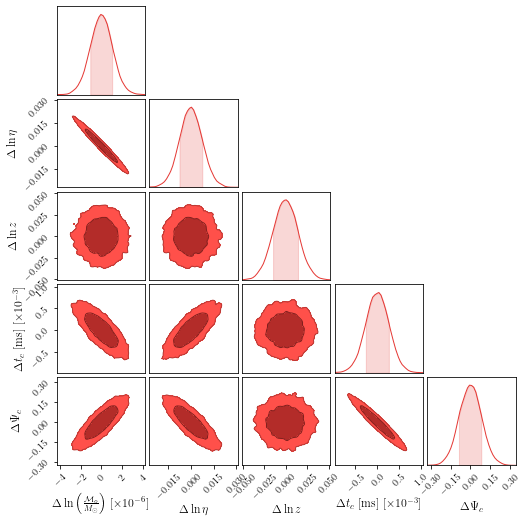

In [19]:
cc = ChainConsumer()
cc.add_chain(data_tot_GR, bins=30, smooth=True, parameters=label_GR, name='cross', color='red');
cc.plotter.plot();

# Step function (no dist corr)

In [20]:
cT_type = 'step'

# Set parameters for step
fstar = 1
c0    = 1 #-1e-7
w1    = 1e-3

# Set parameters for runs and evaluate
pars_MG  = np.append(pars_GR[:-2], [c0, fstar])
fid_vals = np.append(pars_GR[:-2], [c0])
label_MG = label_GR +[r'$\delta c$']

ppars_MG      = np.array(pars_MG[:-1])
ppars_MG[-1]  -= c0
llabel_MG     = label_MG.copy()
llabel_MG[-1] = r'$ \delta c$'

/tmp/ipykernel_5337/4115915249.py:5: UserWarning: Attempting to set identical bottom == top == 1 results in singular transformations; automatically expanding.
  plt.ylim(1 - 2* (1 - c0), 1 +2* (1 - c0))


(0.1, 10.0)

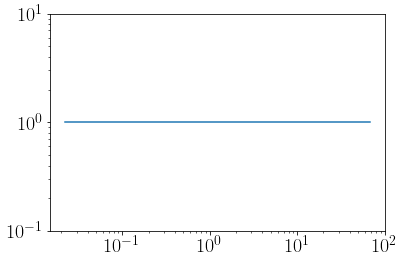

In [21]:
# Evaluate and plot Delta
cT_fo = get_cT(farr, f0=fstar, c0=c0, cT_type=cT_type)

plt.loglog(farr, cT_fo, label='cT fo')
plt.ylim(1 - 2* (1 - c0), 1 +2* (1 - c0))

In [22]:
### LIGO
h_Delta_ligo = h_Delta_inspiral(farr_ligo, pars_MG, cT_type=cT_type, dist_corr=False)

# Derivative for LIGO
dlnA_ligo_MGND, dPsi_ligo_MGND = Fisher_der(farr_ligo, pars_MG, cT_type=cT_type, dist_corr=False)

#dlnA_ligo_MGND   = np.vstack( (dlnA_ligo_MGND, np.zeros(len(farr_ligo)) ))
#dPsi_ligo_MGND   = np.vstack( (dPsi_ligo_MGND, np.zeros(len(farr_ligo)) ))

FlnA_ligo_MGND   = Fisher_build(farr_ligo, ligo_psd, h_Delta_ligo, dlnA_ligo_MGND)
FPsi_ligo_MGND   = Fisher_build(farr_ligo, ligo_psd, h_Delta_ligo, dPsi_ligo_MGND)

fisher_ligo_MGND = FlnA_ligo_MGND +FPsi_ligo_MGND

print('\nLIGO conditioning (units of 1e15)')
print(np.linalg.cond(fisher_ligo_MGND)/1e15)

evals_ligo_MGND, evecs_ligo_MGND = np.linalg.eigh(fisher_ligo_MGND)
print('\nEigenvals:\n', evals_ligo_MGND)

print('\nSmallest eigenval:\n', evecs_ligo_MGND[0,:])
print('\nLargest eigenval:\n', evecs_ligo_MGND[-1,:])

-Working on index 0
Ratio best = 2.80e-14 for dx = 3.34e-01
Ratio best = 5.68e-03 for dx = 1.67e-01
-Working on index 1
Ratio best = 2.42e-03 for dx = 1.40e-01
-Working on index 2
-Working on index 3
-Working on index 4
-Working on index 5
This took 2.65 seconds

LIGO conditioning (units of 1e15)
inf

Eigenvals:
 [0.00000000e+00 3.10464357e+01 1.20242794e+03 4.85927535e+03
 7.19927600e+06 3.33717898e+08]

Smallest eigenval:
 [ 0.          0.01998932 -0.07712216  0.00602871  0.99589081 -0.04263512]

Largest eigenval:
 [ 1.  0.  0.  0.  0. -0.]


In [23]:
### LISA
h_Delta_lisa = h_Delta_inspiral(farr_lisa, pars_MG, cT_type=cT_type, dist_corr=False)

# Derivative for LISA
dlnA_lisa_MGND, dPsi_lisa_MGND = Fisher_der(farr_lisa, pars_MG, cT_type=cT_type, dist_corr=False)

FlnA_lisa_MGND   = Fisher_build(farr_lisa, lisa_psd, h_Delta_lisa, dlnA_lisa_MGND)
FPsi_lisa_MGND   = Fisher_build(farr_lisa, lisa_psd, h_Delta_lisa, dPsi_lisa_MGND)

fisher_lisa_MGND = FlnA_lisa_MGND +FPsi_lisa_MGND

print('\nLISA conditioning (units of 1e15)')
print(np.linalg.cond(fisher_lisa_MGND)/1e15)

evals_lisa_MGND, evecs_lisa_MGND = np.linalg.eigh(fisher_lisa_MGND)
print('\nEigenvals:\n', evals_lisa_MGND)

print('\nSmallest eigenval:\n', evecs_lisa_MGND[0,:])
print('\nLargest eigenval:\n', evecs_lisa_MGND[-1,:])

-Working on index 0
Ratio best = 1.70e-14 for dx = 3.34e-01
Ratio best = 5.67e-03 for dx = 1.67e-01
-Working on index 1
Ratio best = 3.41e-03 for dx = 1.40e-01
-Working on index 2
-Working on index 3
-Working on index 4
-Working on index 5
This took 2.15 seconds

LISA conditioning (units of 1e15)
200205155924133.22

Eigenvals:
 [-7.10542736e-15  4.67898525e-02  1.17981521e-01  2.50508268e+01
  9.08091173e+03  4.13409959e+14]

Smallest eigenval:
 [ 4.16199899e-21  1.03094466e-06 -1.79828868e-06  2.85588952e-11
  1.40007981e-04  9.99999990e-01]

Largest eigenval:
 [ 7.27784738e-01  4.04825775e-07 -7.08158523e-07  6.85805640e-01
 -1.51797974e-07 -2.37499109e-14]


In [24]:
fisher_tot_MGND = fisher_ligo_MGND +fisher_lisa_MGND

print('\nTOT conditioning (units of 1e15)')
print(np.linalg.cond(fisher_tot_MGND)/1e15)

evals_tot_MGND, evecs_tot_MGND = np.linalg.eigh(fisher_tot_MGND)
print('\nEigenvals:\n', evals_tot_MGND)

print('\nSmallest eigenval:\n', evecs_tot_MGND[0,:])
print('\nLargest eigenval:\n', evecs_tot_MGND[-1,:])


TOT conditioning (units of 1e15)
0.03518435133165383

Eigenvals:
 [1.17498249e+01 1.44382723e+02 4.84960298e+03 5.63855072e+04
 3.33124302e+08 4.13409967e+14]

Smallest eigenval:
 [-2.83199224e-14  1.05512232e-05 -1.35964175e-09  1.39622694e-04
 -5.30522217e-07  9.99999990e-01]

Largest eigenval:
 [ 9.99996660e-01  2.39678820e-08 -2.58448984e-03 -2.66059974e-08
  1.56367510e-14 -2.37499105e-14]


In [25]:
### Reducing magnitude of some parameters and computing new fisher
rescaling_matrix      = np.eye( len(dlnA_ligo_MGND) )
rescaling_matrix[0,0] = 1e0 #e-3
rescaling_matrix[1,1] = 1e0 #1e-7
rescaling_matrix[2,2] = 1e0
rescaling_matrix[3,3] = 1e0
rescaling_matrix[4,4] = 1e0 #1e-1
rescaling_matrix[5,5] = 1e0 #1e-1

new_dlnA_ligo_MGND = np.matmul(rescaling_matrix, dlnA_ligo_MGND)
new_dPsi_ligo_MGND = np.matmul(rescaling_matrix, dPsi_ligo_MGND)
new_dlnA_lisa_MGND = np.matmul(rescaling_matrix, dlnA_lisa_MGND)
new_dPsi_lisa_MGND = np.matmul(rescaling_matrix, dPsi_lisa_MGND)

new_FlnA_ligo_MGND = Fisher_build(farr_ligo, ligo_psd, h_Delta_ligo, new_dlnA_ligo_MGND)
new_FPsi_ligo_MGND = Fisher_build(farr_ligo, ligo_psd, h_Delta_ligo, new_dPsi_ligo_MGND)
new_FlnA_lisa_MGND = Fisher_build(farr_lisa, lisa_psd, h_Delta_lisa, new_dlnA_lisa_MGND)
new_FPsi_lisa_MGND = Fisher_build(farr_lisa, lisa_psd, h_Delta_lisa, new_dPsi_lisa_MGND)

new_fisher_tot_MGND = new_FlnA_ligo_MGND +new_FPsi_ligo_MGND +new_FlnA_lisa_MGND +new_FPsi_lisa_MGND
print('Conditioning / 1e15:', np.linalg.cond(new_fisher_tot_MGND)/1e15)

evals_tot_MGND, evecs_tot_MGND = np.linalg.eigh(new_fisher_tot_MGND)

print('\nEigenvals:\n', evals_tot_MGND)

print('\nSmallest eigenval:\n', evecs_tot_MGND[0,:])
print('\nLargest eigenval:\n', evecs_tot_MGND[-1,:])

new_cov_tot_MGND    = np.linalg.inv(new_fisher_tot_MGND)

Conditioning / 1e15: 0.03518435133165383

Eigenvals:
 [1.17498249e+01 1.44382723e+02 4.84960298e+03 5.63855072e+04
 3.33124302e+08 4.13409967e+14]

Smallest eigenval:
 [-2.83199224e-14  1.05512232e-05 -1.35964175e-09  1.39622694e-04
 -5.30522217e-07  9.99999990e-01]

Largest eigenval:
 [ 9.99996660e-01  2.39678820e-08 -2.58448984e-03 -2.66059974e-08
  1.56367510e-14 -2.37499105e-14]


In [26]:
cov_tot_MGND = np.matmul(np.matmul(rescaling_matrix, new_cov_tot_MGND), rescaling_matrix)
data_tot_MGND = np.random.multivariate_normal(0 *ppars_MG, cov_tot_MGND, size=20000)

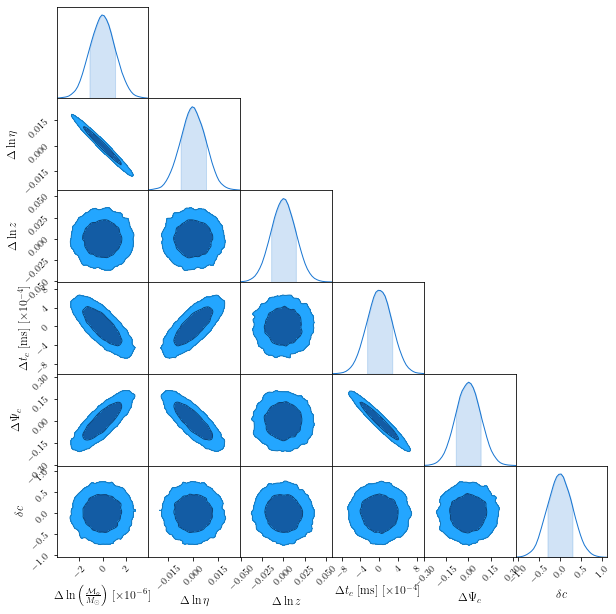

In [27]:
cc = ChainConsumer()
cc.add_chain(data_tot_MGND, bins=30, smooth=True, parameters=llabel_MG, name='cross');
cc.plotter.plot();

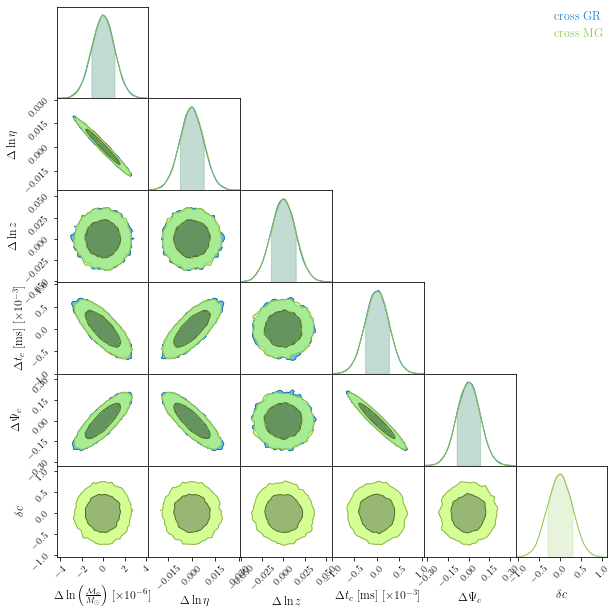

In [28]:
cc = ChainConsumer()
cc.add_chain(data_tot_GR, bins=30, smooth=True, parameters=label_GR, name='cross GR');
cc.add_chain(data_tot_MGND, bins=30, smooth=True, parameters=llabel_MG, name='cross MG');
cc.plotter.plot();

# Step function (dist corr)

In [29]:
### NOW PLUG BACK DIST CORR and recompute derivatives for LIGO!!!
h_Delta_ligo = h_Delta_inspiral(farr_ligo, pars_MG, cT_type=cT_type, dist_corr=True)

# Derivative for LIGO
dlnA_ligo_MGD, dPsi_ligo_MGD = Fisher_der(farr_ligo, pars_MG, cT_type=cT_type, dist_corr=True)

#dlnA_ligo_MGD   = np.vstack( (dlnA_ligo_GRD, np.zeros(len(farr_ligo)) ))
#dPsi_ligo_MGD   = np.vstack( (dPsi_ligo_GRD, np.zeros(len(farr_ligo)) ))

FlnA_ligo_MGD   = Fisher_build(farr_ligo, ligo_psd, h_Delta_ligo, dlnA_ligo_MGD)
FPsi_ligo_MGD   = Fisher_build(farr_ligo, ligo_psd, h_Delta_ligo, dPsi_ligo_MGD)

fisher_ligo_MGD = FlnA_ligo_MGD +FPsi_ligo_MGD

print('\nLIGO conditioning (units of 1e15)')
print(np.linalg.cond(fisher_ligo_MGD)/1e15)

evals_ligo_MGD, evecs_ligo_MGD = np.linalg.eigh(fisher_ligo_MGD)
print('\nEigenvals:\n', evals_ligo_MGD)

print('\nSmallest eigenval:\n', evecs_ligo_MGD[0,:])
print('\nLargest eigenval:\n', evecs_ligo_MGD[-1,:])

-Working on index 0
Ratio best = 2.80e-14 for dx = 3.34e-01
Ratio best = 5.68e-03 for dx = 1.67e-01
-Working on index 1
Ratio best = 2.42e-03 for dx = 1.40e-01
-Working on index 2
-Working on index 3
-Working on index 4
-Working on index 5
This took 2.03 seconds

LIGO conditioning (units of 1e15)
inf

Eigenvals:
 [0.00000000e+00 3.10464357e+01 1.20242794e+03 4.85927535e+03
 7.19927600e+06 3.33717898e+08]

Smallest eigenval:
 [ 0.          0.01998932 -0.07712216  0.00602871  0.99589081 -0.04263512]

Largest eigenval:
 [ 1.  0.  0.  0.  0. -0.]


In [30]:
### NOW PLUG BACK DIST CORR and recompute derivatives for LISA!!!
h_Delta_lisa = h_Delta_inspiral(farr_lisa, pars_MG, cT_type=cT_type, dist_corr=True)

# Derivative for LISA
dlnA_lisa_MGD, dPsi_lisa_MGD = Fisher_der(farr_lisa, pars_MG, cT_type=cT_type, dist_corr=True)

FlnA_lisa_MGD   = Fisher_build(farr_lisa, lisa_psd, h_Delta_lisa, dlnA_lisa_MGD)
FPsi_lisa_MGD   = Fisher_build(farr_lisa, lisa_psd, h_Delta_lisa, dPsi_lisa_MGD)

fisher_lisa_MGD = FlnA_lisa_MGD +FPsi_lisa_MGD

print('\nLISA conditioning (units of 1e15)')
print(np.linalg.cond(fisher_lisa_MGD)/1e15)

evals_lisa_MGD, evecs_lisa_MGD = np.linalg.eigh(fisher_lisa_MGD)
print('\nEigenvals:\n', evals_lisa_MGD)

print('\nSmallest eigenval:\n', evecs_lisa_MGD[0,:])
print('\nLargest eigenval:\n', evecs_lisa_MGD[-1,:])

-Working on index 0
Ratio best = 1.70e-14 for dx = 3.34e-01
Ratio best = 5.67e-03 for dx = 1.67e-01
-Working on index 1
Ratio best = 3.41e-03 for dx = 1.40e-01
-Working on index 2
-Working on index 3
-Working on index 4
-Working on index 5
This took 2.54 seconds

LISA conditioning (units of 1e15)
3.8341529641614294e+33

Eigenvals:
 [-2.44814222e+14 -1.03483249e+06  1.77603348e-15  1.32686871e+01
  4.37777988e+01  1.05088882e+33]

Smallest eigenval:
 [ 9.99999992e-01  1.28543847e-04 -6.17179076e-24 -5.67284433e-14
 -8.81944854e-07  4.30705406e-10]

Largest eigenval:
 [-4.30705395e-10 -1.13908882e-13  2.57336851e-17  8.43724225e-23
  8.30932545e-16  1.00000000e+00]


In [31]:
### LIGO GR vs LIGO MG with distance
np.where( np.abs( fisher_ligo_MGD[:-1,:][:,:-1] - fisher_ligo_GR ) > 1e-10 )  

(array([], dtype=int64), array([], dtype=int64))

In [142]:
### Amplitude part of LISA GR vs LISA MG with distance
#np.where( np.abs( FlnA_lisa_MGD[:-1,:][:,:-1] - FlnA_lisa_GRD ) > 1e-10 )  

In [143]:
### Amplitude part of LISA GR vs LISA MG with distance
#np.where( np.abs( FPsi_lisa_MGD[:-1,:][:,:-1] - FPsi_lisa_GRD ) > 1e-10 )  

In [144]:
#(FlnA_lisa_MGD +FPsi_lisa_MGD )[:-1,:][:,:-1] -FlnA_lisa_GRD -FPsi_lisa_GRD

In [145]:
#fisher_lisa_MGD[:-1,:][:,:-1] / fisher_lisa_GRD

In [146]:
#FPsi_lisa_MGD[2] / FPsi_lisa_MGD[-1]

In [49]:
### Reducing magnitude of some parameters and computing new fisher
rescaling_matrix      = np.eye( len(dlnA_lisa_MGD) )
rescaling_matrix[0,0] = 1e0 #e-3
rescaling_matrix[1,1] = 1e0 #1e-7
rescaling_matrix[2,2] = 1e0
rescaling_matrix[3,3] = 1e0
rescaling_matrix[4,4] = 1e0 #1e-1
rescaling_matrix[5,5] = 1e-15 #1e-1

new_dlnA_ligo_MGD = np.matmul(rescaling_matrix, dlnA_ligo_MGD)
new_dPsi_ligo_MGD = np.matmul(rescaling_matrix, dPsi_ligo_MGD)

new_dlnA_lisa_MGD  = np.matmul(rescaling_matrix, dlnA_lisa_MGD)
new_dPsi_lisa_MGD  = np.matmul(rescaling_matrix, dPsi_lisa_MGD)


new_FlnA_ligo_MGD = Fisher_build(farr_ligo, ligo_psd, h_Delta_ligo, new_dlnA_ligo_MGD)
new_FPsi_ligo_MGD = Fisher_build(farr_ligo, ligo_psd, h_Delta_ligo, new_dPsi_ligo_MGD)

new_FlnA_lisa_MGD  = Fisher_build(farr_lisa, lisa_psd, h_Delta_lisa, new_dlnA_lisa_MGD)
new_FPsi_lisa_MGD  = Fisher_build(farr_lisa, lisa_psd, h_Delta_lisa, new_dPsi_lisa_MGD)

new_fisher_tot_MGD = new_FlnA_ligo_MGD +new_FPsi_ligo_MGD +new_FlnA_lisa_MGD +new_FPsi_lisa_MGD

print('Conditioning / 1e15:', np.linalg.cond(new_fisher_tot_MGD)/1e15)

evals_tot_MGD, evecs_tot_MGD = np.linalg.eigh(new_fisher_tot_MGD)

print('\nEigenvals:\n', evals_tot_MGD)

print('\nSmallest eigenval:\n', evecs_tot_MGD[0,:])
print('\nLargest eigenval:\n', evecs_tot_MGD[-1,:])

evals_tot_MGD = np.abs(evals_tot_MGD) +1e-20 *np.max(evals_tot_MGD)

new_cov_tot_MGD    = np.matmul( np.matmul(evecs_tot_MGD, np.diag(1/evals_tot_MGD)), evecs_tot_MGD.T )

Conditioning / 1e15: 0.003851943320816764

Eigenvals:
 [1.07325039e+02 5.24957984e+02 4.84957067e+03 5.64529391e+04
 3.33124302e+08 4.13409967e+14]

Smallest eigenval:
 [ 1.18320998e-05  2.53109713e-06  1.32729255e-09  1.39501321e-04
 -5.30522193e-07  9.99999990e-01]

Largest eigenval:
 [-2.97701986e-01 -9.54027583e-01  5.31239343e-06  3.47116586e-02
 -2.21727344e-08  1.09485387e-06]


In [50]:
cov_tot_MGD   = np.matmul(np.matmul(rescaling_matrix, new_cov_tot_MGD), rescaling_matrix)
data_tot_MGD  = np.random.multivariate_normal(0 *ppars_MG, cov_tot_MGD, size=20000)

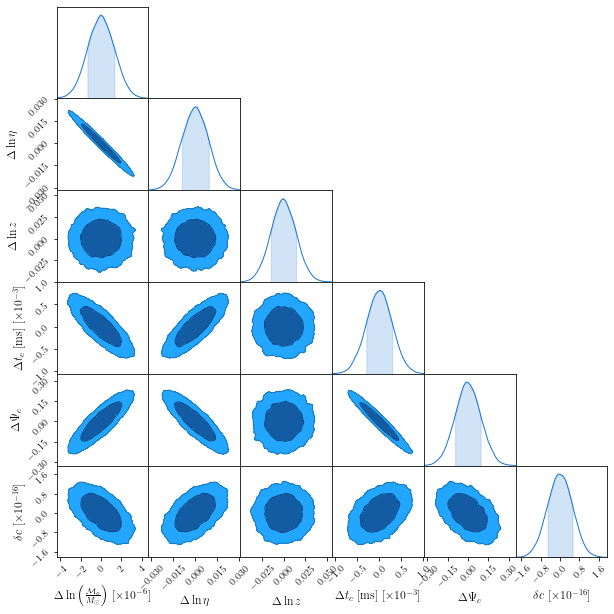

In [51]:
cc = ChainConsumer()
#cc.add_chain(data_tot_MGND, bins=30, smooth=True, parameters=llabel_MG, name='cross MG no dist');
cc.add_chain(data_tot_MGD, bins=30, smooth=True, parameters=llabel_MG, name='cross MG dist');
cc.plotter.plot();

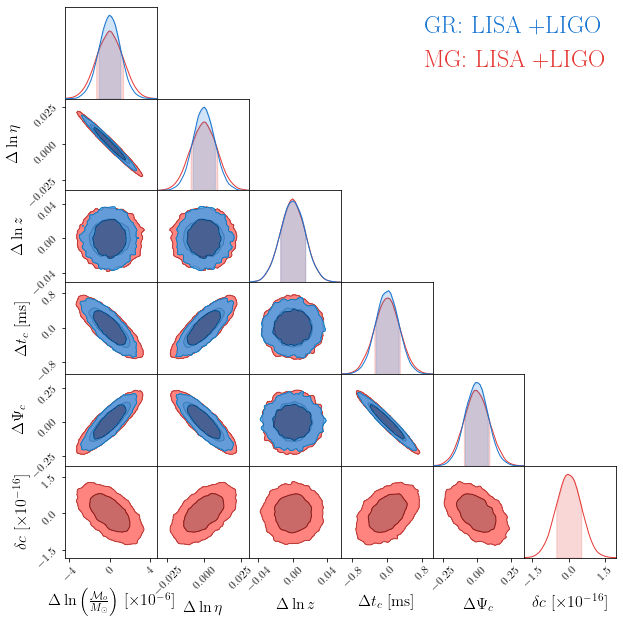

In [52]:
cc = ChainConsumer()

my_data_tot_GR = np.array(data_tot_GR)
my_data_tot_GR[:,3] *= 1e3

my_data_tot_MGD = np.array(data_tot_MGD)
my_data_tot_MGD[:,3] *= 1e3

cc.add_chain(my_data_tot_GR, bins=30, smooth=True, parameters=label_GR, name='GR: LISA +LIGO',  zorder=3, color='blue');
#cc.add_chain(data_tot_MGND, bins=30, smooth=True, parameters=llabel_MG, name='LISA +LIGO MG no $\Delta t$',  zorder=2);
cc.add_chain(my_data_tot_MGD, bins=30, smooth=True, parameters=llabel_MG, name='MG: LISA +LIGO',  zorder=1, color='red');
cc.configure(legend_kwargs={"loc": "upper right", "fontsize": 24}, max_ticks=3, label_font_size=16, tick_font_size=12);
cc.plotter.plot();

plt.savefig('Final_plot.pdf')

In [170]:
1e-3 / get_dL_Mpc(zem) /Mpc *c

2.3608885448865244e-20

In [188]:
3.6247988851978787 / (get_dL_Mpc(zem) *Mpc / c )

8.557746165581115e-17

In [183]:
np.std(my_data_tot_MGD[:,-1])

5.045010431386093e-17

In [187]:
np.std(data_lisa_GR[:,-2])

3.6247988851978787